<a href="https://colab.research.google.com/github/migub/recommender-systems/blob/main/Notebooks/Music_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Created output directory: output_insights_20250309_142557
Loading dataset...
Dataset shape: (7558834, 15)
Unique users: 19918
Unique artists: 67142
Unique songs: 452975

=== POPULARITY-BASED RECOMMENDATION METRICS ===

Top 10 Most Popular Songs:
    media_id  count
0  132434634  20148
1  133165774  17652
2  132123604  16289
3  132123626  15131
4  132123630  14347
5  129632340  13076
6  131576046  12709
7  132614858  12394
8  134748108  12257
9  133661814  11663

Top 10 Most Popular Artists:
   artist_id   count
0    1519461  163420
1    1191615  161416
2     388973  103643
3        390   75457
4     246791   49879
5      13011   48188
6    5876247   48074
7    4429712   47384
8       3469   43374
9    5542343   39524


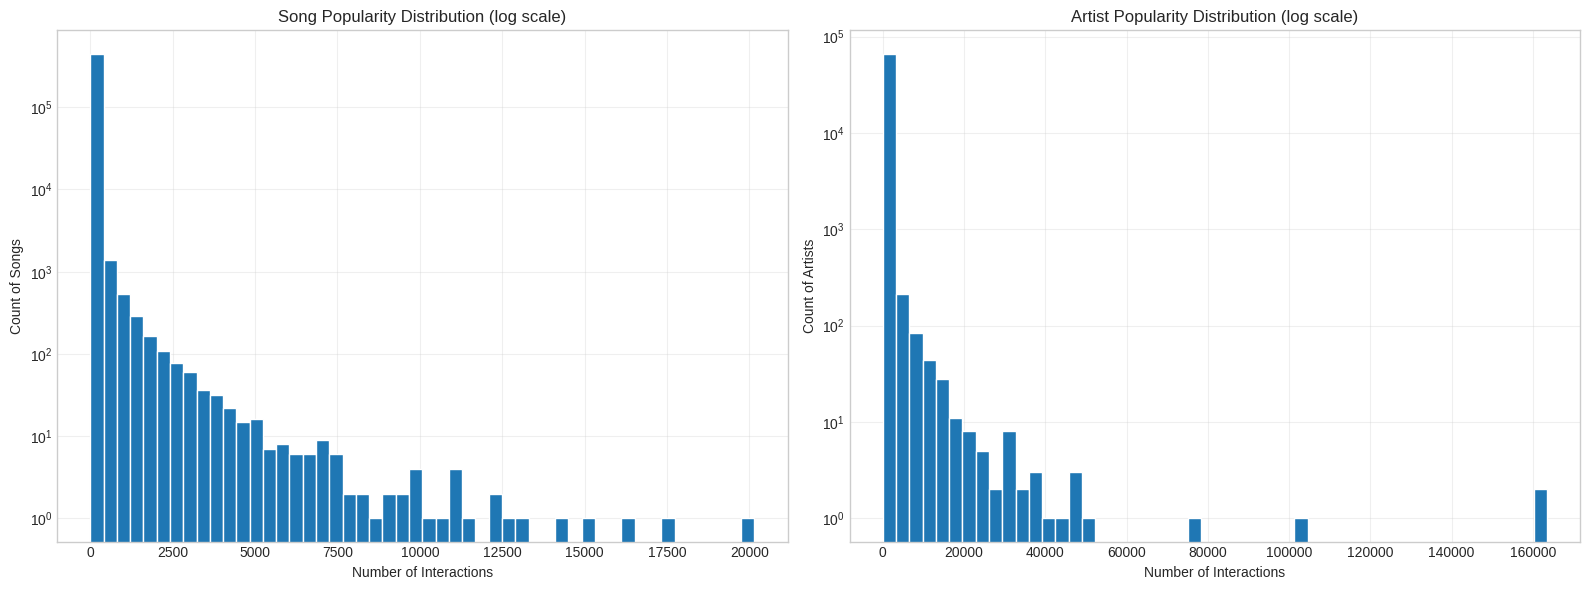


Popularity Concentration Metrics:
Top 1% artists (671 artists) account for 65.75% of all interactions
Top 5% artists (3357 artists) account for 87.60% of all interactions
Top 10% artists (6714 artists) account for 93.30% of all interactions


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
import os
from datetime import datetime

# Create output directory with timestamp to avoid overwriting previous results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f'output_insights_{timestamp}'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Created output directory: {output_dir}")

# Set visual styles
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/Recommender_Systems/train.csv')

# Basic Dataset Info
print(f"Dataset shape: {df.shape}")
print(f"Unique users: {df['user_id'].nunique()}")
print(f"Unique artists: {df['artist_id'].nunique()}")
print(f"Unique songs: {df['media_id'].nunique()}")

# ============================
# POPULARITY-BASED ANALYSIS
# ============================
print("\n=== POPULARITY-BASED RECOMMENDATION METRICS ===")

# Most popular songs (by interaction count)
popular_songs = df['media_id'].value_counts().reset_index()
popular_songs.columns = ['media_id', 'count']
print("\nTop 10 Most Popular Songs:")
print(popular_songs.head(10))

# Most popular artists (by interaction count)
popular_artists = df['artist_id'].value_counts().reset_index()
popular_artists.columns = ['artist_id', 'count']
print("\nTop 10 Most Popular Artists:")
print(popular_artists.head(10))

# Visualize popularity distribution
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
popular_songs['count'].hist(bins=50, log=True)
plt.title('Song Popularity Distribution (log scale)')
plt.xlabel('Number of Interactions')
plt.ylabel('Count of Songs')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
popular_artists['count'].hist(bins=50, log=True)
plt.title('Artist Popularity Distribution (log scale)')
plt.xlabel('Number of Interactions')
plt.ylabel('Count of Artists')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate popularity concentration metrics
print("\nPopularity Concentration Metrics:")
total_interactions = len(df)
artist_interactions = df['artist_id'].value_counts().reset_index()
artist_interactions.columns = ['artist_id', 'count']
artist_interactions['percentage'] = artist_interactions['count'] / total_interactions * 100

top_1_percent_artists = int(len(artist_interactions) * 0.01)
if top_1_percent_artists == 0:
    top_1_percent_artists = 1
top_5_percent_artists = int(len(artist_interactions) * 0.05)
if top_5_percent_artists == 0:
    top_5_percent_artists = 1
top_10_percent_artists = int(len(artist_interactions) * 0.1)
if top_10_percent_artists == 0:
    top_10_percent_artists = 1

print(f"Top 1% artists ({top_1_percent_artists} artists) account for {artist_interactions.head(top_1_percent_artists)['percentage'].sum():.2f}% of all interactions")
print(f"Top 5% artists ({top_5_percent_artists} artists) account for {artist_interactions.head(top_5_percent_artists)['percentage'].sum():.2f}% of all interactions")
print(f"Top 10% artists ({top_10_percent_artists} artists) account for {artist_interactions.head(top_10_percent_artists)['percentage'].sum():.2f}% of all interactions")

# Calculate Gini coefficient for artist popularity (measure of inequality)
def gini_coefficient(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad / np.mean(x)
    # Gini coefficient
    return 0.5 * rmad

artist_gini = gini_coefficient(artist_interactions['count'].values)
print(f"Artist popularity Gini coefficient: {artist_gini:.4f} (0=perfect equality, 1=perfect inequality)")

# ============================
# USER BEHAVIOR ANALYSIS
# ============================
print("\n=== USER BEHAVIOR ANALYSIS ===")

# User interaction counts
user_counts = df['user_id'].value_counts().reset_index()
user_counts.columns = ['user_id', 'interactions']

# Calculate user engagement statistics
print("\nUser Engagement Statistics:")
print(f"Mean interactions per user: {user_counts['interactions'].mean():.2f}")
print(f"Median interactions per user: {user_counts['interactions'].median():.2f}")
print(f"Min interactions: {user_counts['interactions'].min()}")
print(f"Max interactions: {user_counts['interactions'].max()}")

# User diversity - how many unique artists per user
user_artist_diversity = df.groupby('user_id')['artist_id'].nunique().reset_index()
user_artist_diversity.columns = ['user_id', 'unique_artists']

print("\nUser Artist Diversity:")
print(f"Mean unique artists per user: {user_artist_diversity['unique_artists'].mean():.2f}")
print(f"Median unique artists per user: {user_artist_diversity['unique_artists'].median():.2f}")
print(f"Max unique artists for a user: {user_artist_diversity['unique_artists'].max()}")

# Visualize the distribution
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(user_counts['interactions'], kde=True, bins=50)
plt.title('User Interaction Count Distribution')
plt.xlabel('Number of Interactions')
plt.ylabel('Count of Users')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.histplot(user_artist_diversity['unique_artists'], kde=True, bins=50)
plt.title('User Artist Diversity Distribution')
plt.xlabel('Number of Unique Artists')
plt.ylabel('Count of Users')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Loyalty metric - what percentage of a user's interactions are with their top artist
user_artist_counts = df.groupby(['user_id', 'artist_id']).size().reset_index(name='counts')
user_total_plays = user_artist_counts.groupby('user_id')['counts'].sum().reset_index()
user_artist_counts = user_artist_counts.merge(user_total_plays, on='user_id')
user_artist_counts['percentage'] = user_artist_counts['counts_x'] / user_artist_counts['counts_y'] * 100

# Get the artist with highest percentage for each user
top_artist_percentage = user_artist_counts.sort_values(['user_id', 'percentage'], ascending=[True, False])
top_artist_percentage = top_artist_percentage.groupby('user_id').first().reset_index()

print("\nUser Loyalty (Percentage of interactions with top artist):")
print(f"Mean: {top_artist_percentage['percentage'].mean():.2f}%")
print(f"Median: {top_artist_percentage['percentage'].median():.2f}%")
print(f"Min: {top_artist_percentage['percentage'].min():.2f}%")
print(f"Max: {top_artist_percentage['percentage'].max():.2f}%")

# ============================
# COLLABORATIVE FILTERING POTENTIAL
# ============================
print("\n=== COLLABORATIVE FILTERING POTENTIAL ===")

# Create user-item matrix
user_ids = df['user_id'].unique()
item_ids = df['media_id'].unique()
user_id_map = {id: i for i, id in enumerate(user_ids)}
item_id_map = {id: i for i, id in enumerate(item_ids)}

# Create interaction matrix
rows = df['user_id'].map(user_id_map).values
cols = df['media_id'].map(item_id_map).values
data = np.ones(len(df))

user_item_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(item_ids)))

# Calculate sparsity
sparsity = 1.0 - (len(df) / (len(user_ids) * len(item_ids)))
print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.2f}%)")

# Compute number of co-interactions
# (how many users have interacted with pairs of items)
if len(item_ids) < 1000:  # Only compute for smaller datasets
    print("\nComputing item-item co-interactions matrix...")

    # Create dictionary to store item co-occurrence
    item_co_interaction = defaultdict(lambda: defaultdict(int))

    # Group by user and get item interactions
    user_items = df.groupby('user_id')['media_id'].apply(list).reset_index()

    # Process each user's items
    for _, row in user_items.iterrows():
        items = row['media_id']
        for i in range(len(items)):
            for j in range(i+1, len(items)):
                item1, item2 = sorted([items[i], items[j]])
                item_co_interaction[item1][item2] += 1

    # Convert to pandas DataFrame for easier analysis
    co_interaction_data = []
    for item1 in item_co_interaction:
        for item2 in item_co_interaction[item1]:
            co_interaction_data.append((item1, item2, item_co_interaction[item1][item2]))

    co_df = pd.DataFrame(co_interaction_data, columns=['item1', 'item2', 'co_interactions'])

    # Some statistics about co-interactions
    print(f"Total item pairs with co-interactions: {len(co_df)}")
    print(f"Maximum co-interactions for an item pair: {co_df['co_interactions'].max()}")
    print(f"Average co-interactions per item pair: {co_df['co_interactions'].mean():.2f}")

    # Most common co-interactions
    print("\nTop 10 Item Pairs with Most Co-interactions:")
    print(co_df.sort_values('co_interactions', ascending=False).head(10))
else:
    print("Item-item co-interaction computation skipped due to large dataset size")

# ============================
# ARTIST SIMILARITY ANALYSIS
# ============================
print("\n=== ARTIST SIMILARITY ANALYSIS ===")

# Create user-artist matrix
user_ids = df['user_id'].unique()
artist_ids = df['artist_id'].unique()
user_id_map = {id: i for i, id in enumerate(user_ids)}
artist_id_map = {id: i for i, id in enumerate(artist_ids)}

rows = df['user_id'].map(user_id_map).values
cols = df['artist_id'].map(artist_id_map).values
data = np.ones(len(df))

user_artist_matrix = csr_matrix((data, (rows, cols)), shape=(len(user_ids), len(artist_ids)))

# Get top 5 most popular artists
top_artists = popular_artists.head(5)['artist_id'].values
top_artist_indices = [artist_id_map[artist] for artist in top_artists if artist in artist_id_map]

if len(top_artist_indices) > 0:
    # Calculate artist similarity
    print("\nCalculating artist similarity for top artists...")
    artist_similarity = cosine_similarity(user_artist_matrix.T)

    # Get similar artists for top artists
    for i, artist_idx in enumerate(top_artist_indices):
        artist_id = top_artists[i]
        sim_scores = list(enumerate(artist_similarity[artist_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:6]  # top 5 similar artists excluding self

        print(f"\nArtists similar to {artist_id}:")
        for idx, score in sim_scores:
            similar_artist = [a for a, i in artist_id_map.items() if i == idx][0]
            print(f"  {similar_artist}: {score:.4f} similarity")

# ============================
# COLD START PROBLEM ANALYSIS
# ============================
print("\n=== COLD START PROBLEM ANALYSIS ===")

# Identify potential cold start users and items
user_interaction_counts = df.groupby('user_id').size()
cold_users = user_interaction_counts[user_interaction_counts < 5].index
print(f"Number of cold-start users (< 5 interactions): {len(cold_users)} ({len(cold_users)/len(user_ids)*100:.2f}%)")

item_interaction_counts = df.groupby('media_id').size()
cold_items = item_interaction_counts[item_interaction_counts < 5].index
print(f"Number of cold-start items (< 5 interactions): {len(cold_items)} ({len(cold_items)/len(item_ids)*100:.2f}%)")

# Plot distribution of interaction counts
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
user_interaction_counts.plot(kind='hist', bins=50, log=True)
plt.axvline(x=5, color='r', linestyle='--', label='Cold-start threshold')
plt.title('User Interaction Count Distribution')
plt.xlabel('Number of Interactions')
plt.ylabel('Count of Users (log scale)')
plt.legend()

plt.subplot(1, 2, 2)
item_interaction_counts.plot(kind='hist', bins=50, log=True)
plt.axvline(x=5, color='r', linestyle='--', label='Cold-start threshold')
plt.title('Item Interaction Count Distribution')
plt.xlabel('Number of Interactions')
plt.ylabel('Count of Items (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

# ============================
# RECOMMENDATION CHALLENGE METRICS
# ============================
print("\n=== RECOMMENDATION CHALLENGE METRICS ===")

# Calculate long-tail percentage (items with few interactions)
long_tail_threshold = item_interaction_counts.median()
long_tail_items = item_interaction_counts[item_interaction_counts <= long_tail_threshold].index
print(f"Long-tail items (≤ {long_tail_threshold} interactions): {len(long_tail_items)} ({len(long_tail_items)/len(item_ids)*100:.2f}%)")

# Create segments of users by activity level
user_segments = pd.cut(user_interaction_counts,
                       bins=[0, 5, 10, 25, 50, 100, float('inf')],
                       labels=['Very Low (1-5)', 'Low (6-10)', 'Medium (11-25)',
                               'High (26-50)', 'Very High (51-100)', 'Super (>100)'])
segment_counts = user_segments.value_counts().sort_index()

plt.figure(figsize=(12, 6))
segment_counts.plot(kind='bar')
plt.title('User Segments by Activity Level')
plt.xlabel('Activity Segment')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nUser segments by activity level:")
for segment, count in segment_counts.items():
    print(f"  {segment}: {count} users ({count/len(user_ids)*100:.2f}%)")

# ============================
# INTERACTION DIVERSITY ANALYSIS
# ============================
print("\n=== INTERACTION DIVERSITY ANALYSIS ===")

# Check if typical users interact with popular and non-popular content
# For each user, calculate the percentage of their interactions with top 10% popular items
top_10pct_items = set(popular_songs.head(int(len(popular_songs)*0.1))['media_id'])
user_item_interactions = df.groupby('user_id')['media_id'].apply(list)

user_popular_pcts = []
for user, items in user_item_interactions.items():
    items_set = set(items)
    popular_items = items_set.intersection(top_10pct_items)
    pct_popular = len(popular_items) / len(items_set) * 100
    user_popular_pcts.append(pct_popular)

popular_interaction_pcts = pd.Series(user_popular_pcts)

plt.figure(figsize=(10, 6))
sns.histplot(popular_interaction_pcts, bins=20, kde=True)
plt.title('Percentage of User Interactions with Popular Items (Top 10%)')
plt.xlabel('Percentage of Popular Items in User Profile')
plt.ylabel('Number of Users')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average percentage of popular items in user profiles: {popular_interaction_pcts.mean():.2f}%")
print(f"Median percentage of popular items in user profiles: {popular_interaction_pcts.median():.2f}%")

# ============================
# SUMMARY AND RECOMMENDATIONS
# ============================
print("\n=== RECOMMENDATION SYSTEM INSIGHTS ===")
print("\nBased on the analysis, here are some key insights for your music recommendation system:")

# Matrix sparsity insights
if sparsity > 0.995:
    print("- Very high matrix sparsity suggests focusing on model-based collaborative filtering rather than memory-based")
else:
    print("- Matrix density is sufficient for both memory-based and model-based collaborative filtering")

# Popular vs. long tail
popular_item_pct = len(popular_songs[popular_songs['count'] > popular_songs['count'].median()]) / len(popular_songs) * 100
print(f"- {popular_item_pct:.1f}% of items are above median popularity, suggesting {'a strong' if popular_item_pct < 20 else 'a moderate' if popular_item_pct < 40 else 'a weak'} long-tail effect")

# Cold start issues
cold_user_pct = len(cold_users) / len(user_ids) * 100
cold_item_pct = len(cold_items) / len(item_ids) * 100
print(f"- Cold-start issues affect {cold_user_pct:.1f}% of users and {cold_item_pct:.1f}% of items")
if cold_user_pct > 30 or cold_item_pct > 30:
    print("  Consider hybrid approaches or content-based methods to address significant cold-start challenges")

# User loyalty insights
mean_loyalty = top_artist_percentage['percentage'].mean()
if mean_loyalty > 50:
    print("- Users show high loyalty to favorite artists, suggesting artist-based recommendations may be effective")
else:
    print("- Users show diversity in artist preferences, suggesting more varied recommendations")

# Recommendation approach suggestions
print("\nPotential recommendation approaches:")
print("1. Collaborative Filtering:")
if sparsity > 0.995:
    print("   - Matrix Factorization (e.g., SVD, ALS) to handle high sparsity")
else:
    print("   - User-based and Item-based methods could work well")

print("2. Content-Based Filtering:")
if 'media_duration' in df.columns or 'release_date' in df.columns:
    print("   - Leverage song metadata features for recommendations")
print("   - Use artist similarity metrics for similar artist recommendations")

print("3. Hybrid Methods:")
if cold_user_pct > 20 or cold_item_pct > 20:
    print("   - Combine collaborative and content approaches to address cold-start")
print("   - Consider popularity-based fallbacks for new users")

print("4. Advanced Approaches:")
print("   - Deep learning models (e.g., neural collaborative filtering)")
print("   - Sequential recommendation for music playlists")
print("   - Contextual recommendations based on listening patterns")

print("\nEDA for music recommendation system complete!")